This tutorial explains the main features of `SKQudit` and gives details about its implementation. Besides the import cell below, each of the numbered sections can be run separately.

In [12]:
# External imports
import numpy as np

# skqudit import
from skqudit import (
    InstructionSet,
    CompiledGate,
    SimpleNet
)
from skqudit.utils import (
    Rx,
    Rz,
    su2_matrix
)

# 1. The Solovay-Kitaev algorithm
We will here describe the details of Solovay-Kitaev algorithm as in the version by [Dawrson and Nielsen](https://arxiv.org/abs/quant-ph/0505030). To keep things simpler for the general practitioner of quantum computing, in this example, we will only consider only qubits -- that is, we will assume that our goal is to approximate a matrix in $SU(2)$ using only single qubit gates -- and leave the qudit case for the next section.

## 1.1 Quantum compilation
The gate-based paradigm of quantum computing consists of combining elements of some finite set of gates, also called *instructions*, to represent arbitrary $2\times 2$ special unitary matrices, said to live in the group $SU(2)$. Writing a general matrix $U$ in $SU(2)$ as (approximately) a product of instruction gates is known as *quantum compilation*. In particular, once $U$ is compiled, one can equivalently write it as the sequence of instructions, which is exactly the information sent to the [QPU](https://www.ibm.com/think/topics/qpu) and that is implemented in the hardware.

In `SKQudit`, instructions are represented as the object `InstructionSet`. This object is created by taking a dictionary with the instruction names and its matrices representations. No inverses are necessary to initialize the instruction set, these are computed automatically. Once computed, the inverses are represented by the captalized version of the instruction name (e.g., 'S1' is the inverse gate of 's1'). The only requirement is that the instructions are special unitary matrices, that is, we ask for them to be matrices of determinant $+1$ in addition to the unitary property.

In this example, we will use $R_X(\sqrt{2})$ and $R_Z(\sqrt{3})$, that is, a rotation by $\sqrt{2}$ radians along the $X$-axis of the Bloch sphere and a rotation of $\sqrt{3}$ radians along the $Z$-axis. 

In [5]:
s1 = Rx(np.sqrt(2))
s2 = Rz(np.sqrt(3))

instr = {
    's1': s1,
       's2': s2
       }
instr_set = InstructionSet(instr)
print('Instructions: ', instr_set.instrs)

Instructions:  ['s1', 's2', 'S1', 'S2']


Notice that the inverse gates were indeed added to the instruction set. For a long time, the development of a version of SK that does not require inverse gates was a big open problem in theoretical quantum computing, but that was recently solved by [Bouland and Giurgica-Tiro](https://arxiv.org/abs/2112.02040). Our implementation of the algorithm, however, requires inverse.

Once the instructions have been defined, they can be used to compile gates. For such, we refer to the class `CompiledGate`. Let us show an example of this class by considering a circuit that first applies $R_X(\sqrt{2})$, followed by $R_Z(\sqrt{3})$, and $R_X^{-1}(\sqrt{2})$ to a single qubit.

In [9]:
gate = CompiledGate('s1.s2.S1', instr_set)

We can check that this really compiles the expected circuit by considering the total unitary that it represents.

In [10]:
# Matrix product is assumed in the opposite
# order of the gate application
product = s1.conj().T @ s2 @ s1
assert np.allclose(gate.total_unitary, product)

## 1.2 Nets
In the example above, we worked on the direct problem: we had as input a sequence of instructions and computed the desired matrix. In practice, the inverse problem is what we are really intrested about: suppose we are given a matrix in $SU(2)$, can we find a compilation (as in sequence of instructions), which approximates that matrix? Finding such a sequence is exactly the goal of SK.

The first natural question to investigate the inverse problem is whether it really can be solved, that is, whether we can find such an approximate compilation. To characterize instructions sets for which the inverse problem can always be solved, we say that the instruction set is *universal* if there is a compilation that approximate any matrix in $SU(2)$ within any desired level of accuracy. Mathematically, universality can be characterized by the fact that the set of all compilations up to arbitrary lengths is *dense* in $SU(2)$. The instruction set created above is an example of a universal set.

Density itself already gives a very brute force possibility to compute compilations of matrices in $SU(2)$. For such, we define a $L$-net $\mathcal{N}$ as the set of all possible compilations of gates of length at most $L$. For example, in the example above, a 2-net is $\mathcal{N}=\{s1, s2, S1, S2, s1.s1, s1.s2,...,S2.s2\}$. We can simply iterate the net to find an approximation of any desired gate. The code below does just thatuses a 13-net to find an approximation of some matrix in $SU(2)$. Here, we will assume that the matrix to approximate is given by
$$
\exp(i\sigma_X + 2i \sigma_Y + 2i \sigma_Z)
$$
where $\sigma_X, \sigma_Y$ and $\sigma_Z$ are the [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices) in $SU(2)$.

In [18]:
# This code snippet can take up to a minute to run

# Layers is the number of layers we want to build on top of a
# 1-net (i.e., {s1, s2, S1, S2})
layers = 12
net = SimpleNet(instr_set)

_ = net.build_net(layers, verbosity=1)

print('\nSize of net:', len(net.net))

matrix_to_approximate = su2_matrix(1, 2, 2)

compilation, gate_dist = net.search(matrix_to_approximate,
           distance=0.1, # This paraemeter controls how close the compilation has to be to the target matrix
           method='full') # This ensures that we get the best approximate compilation

print('\nBest compilation found: ', compilation.instr)
print('Distance from compilation to target: ', round(gate_dist, 3))

Progress: layer 13 of 13

Size of net: 3188644
|█████████████████████████████-| 99.7%
Best compilation found:  s1.S2.s1.s1.s1.s2.s2.s1.S2.S2.S2.s1
Distance from compilation to target:  0.022


We were able to find a compilation that approximates the matrix at a distance -- or *accuracy* -- of 0.022 (here and throughout, distances and inner-products between matrices are all measured using the [Frobenius norm](https://en.wikipedia.org/wiki/Frobenius_inner_product), that is, $\langle U, V\rangle = \text{tr}(U^\dagger V)$). For reasons that will soon become clear, we will call an $L$-net a $\epsilon_0$-net if any matrices of $SU(2)$ can be approximated by an element of the net with distance, at most, $\epsilon_0$. So, the net above is an $\epsilon_0$-net for some $\epsilon_0 \geq 0.022$.

## 1.3 The Solovay-Kitaev algorithm

A net is good when we have sampled densely enough in all regions (of course, this will always happen at the limit of the number of layers going to infinity, but, in practice, we are often far from this limit). To check how good a net is, especially at the most crucial region (i.e., close to the identity), we can sample the norm of the created gates to the identity.

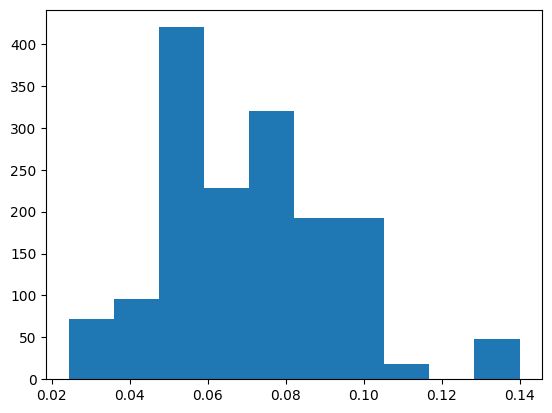

In [33]:
norms = [frobenius_norm(gate.total_unitary, np.eye(2)) for gate in net.net]
small_norms =  [norm for norm in norms if norm < 0.14]
plt.hist(small_norms)
plt.show()

We could also consider the quadratic method for building the net. Its goal is to remove previously generated instructions (or, at least, instructions whose total unitary is close to a previously generated instruction) from the list of instructions, therefore significantly reducing the net size, at the cost of a significant increase in running time. This size of the nets created using the quadratic method can be compared with the nets created from the standard linear search method, so we have an idea of the gains of the former. 

## 1.2 Implementation of Solovay-Kitaev
Here, we will explore the implementation of Solovay-Kitaev applied to a general gate. This gate will be simply given by the exponent of some element of the Lie algebra $\mathfrak{su}(2)$.

|█████████████████████████████-| 99.7%
Instructions (at depth 0):  s1.S2.s1.s1.s1.s2.s2.s1.S2.S2.S2.s1
Distance (at depth 0):  0.022354522483743672
Diagonalized H:
 [[-5.87637577e-17-1.08420217e-19j -1.58071990e-02-5.42101086e-20j]
 [-1.58071990e-02+8.67361738e-19j -5.68121938e-17+5.42101086e-20j]]
Computed F (in diagonal basis):
 [[0.00000000e+00+0.j         1.07793563e-19-0.03143167j]
 [1.72469700e-18+0.03143167j 0.00000000e+00+0.j        ]]
Computed G (in diagonal basis):
 [[-0.25145337  0.        ]
 [ 0.          0.25145337]]
Norms: ||H|| = 0.02235475522167111 , ||F|| = 0.04445109533100539 , ||G|| = 0.355608762648043
Computed F (in normal basis):
 [[1.32475572e-19+6.41416628e-20j 2.90566447e-02-1.19858807e-02j]
 [2.90566447e-02+1.19858807e-02j 3.28528662e-18+2.65329568e-19j]]
Computed G (in normal basis):
 [[ 0.24881118+0.j         0.01386385+0.0336093j]
 [ 0.01386385-0.0336093j -0.24881118+0.j       ]]
Computed brackets: [F, G] =
 [[-5.42101086e-20-0.00228549j -1.44592362e-02+0.00

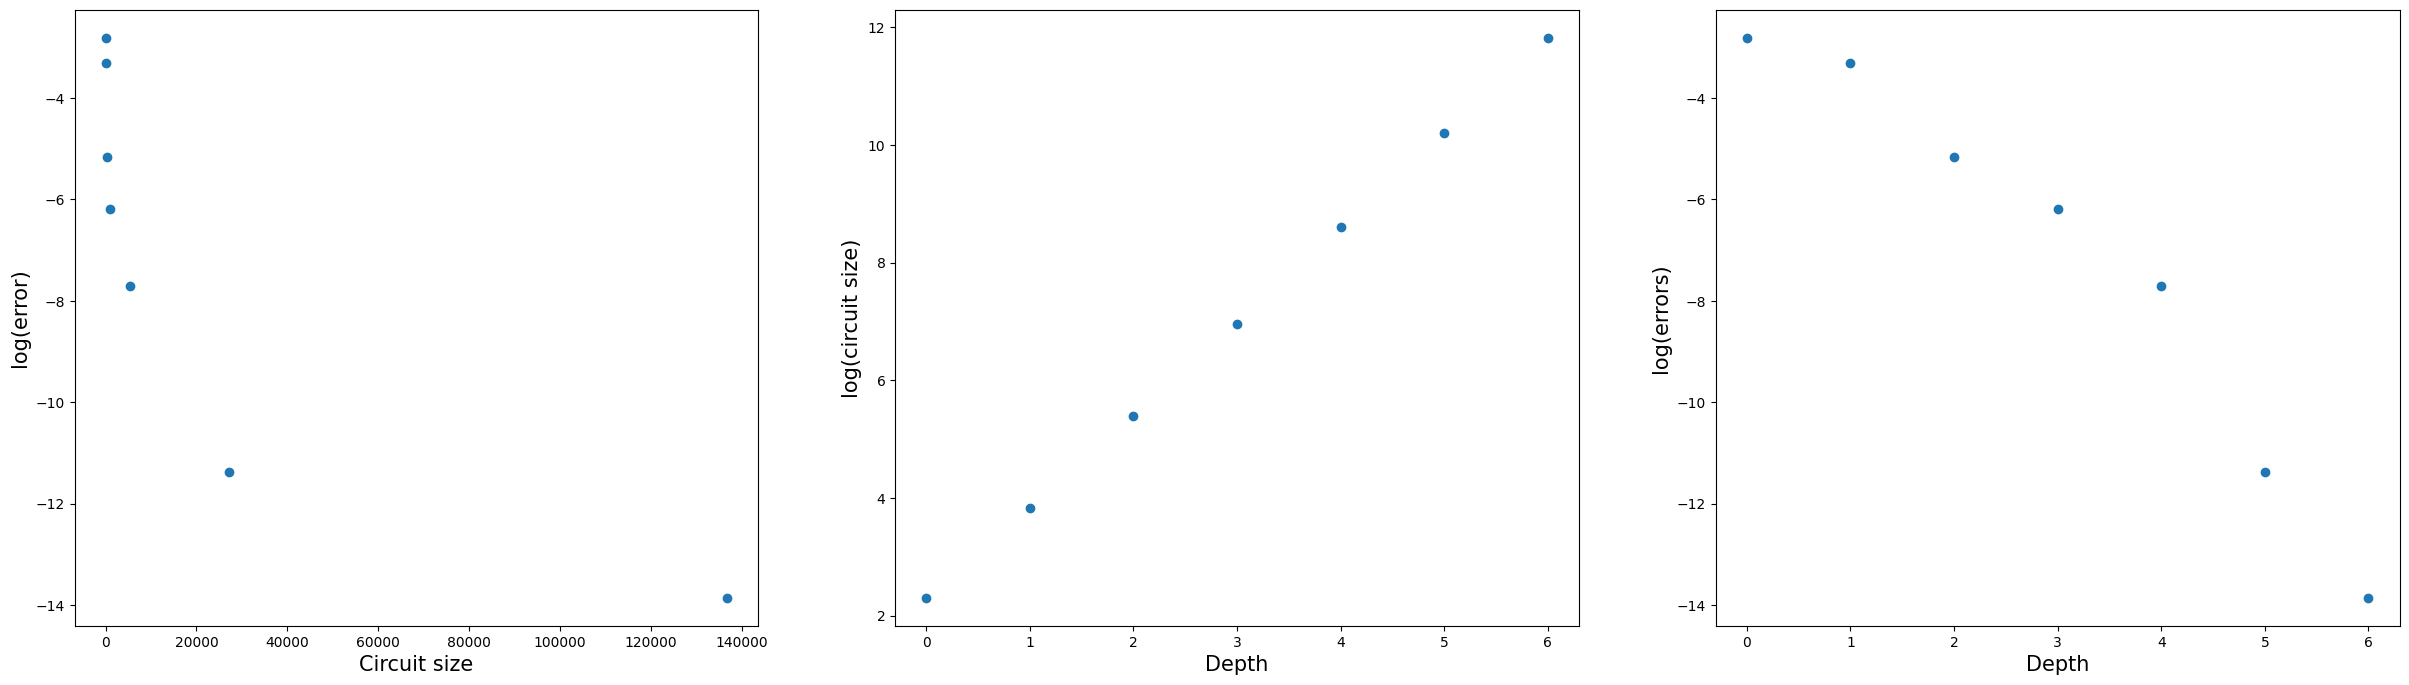

In [34]:
'''
Depth 0th approximation
'''
gate_to_approx = su2_matrix(1, 2, 2)

# Check if indeed special unitary
assert test_special_unitarity(gate_to_approx)

# Do linear search of depth 0
res = net.search(gate_to_approx, distance=0.1, verbosity=1, method='full')
print('\nInstructions (at depth 0): ', res[0].instr)
print('Distance (at depth 0): ', res[1])

'''
Compute commutator
'''
V, W = commutator_approximation(res[0].total_unitary.conj().T @ gate_to_approx, verbosity=2, scale=1)

'''
Explore commutator approximation part
'''
print('W: ', net.search(W, 0.1)[0].instr)
print('V: ', net.search(V, 0.1)[0].instr)

'''
Solovay-Kitaev
'''
print('Depth 0 error: ', res[1])
best_gate, hist = solovay_kitaev(gate_to_approx, 6, net, epsilon_0 = 0.1, verbosity = 3, scale = 2, return_history=True)
plot_history(hist)

## 1.3 Meet in the middle method
Here we will give a look at the meet in the middle method for searching. The main idea is that it uses a divide-and-conquer approach to reduce memory requirements significantly, at a quadratic price to speed. We first check what is the process of approximating our target gate using linear search with early exit (as in the last section). I will redo definitions so we can run this section without running 1.2, which is definitely slower.

In [28]:
print('Layers:', layers)
print('\nSize of net:', len(net))
gate_to_approx = su2_matrix(1, 2, 2)
res = net.search(gate_to_approx, distance=0.1, verbosity=1)
print('\nInstructions (at depth 0): ', res[0].instr)
print('Distance (at depth 0): ', res[1])

Layers: 12

Size of net: 3188644
|------------------------------| 1.3%
Instructions (at depth 0):  s1.s1.S2.S2.s1.s1.s1.S2.S2.s1
Distance (at depth 0):  0.06005928720414511


Now, let us see how things work in the meet in the middle. We just need half the number of layers, which will significantly impact the total size of the net.

In [29]:
small_net = SimpleNet(instr_set=instr_set)
layers = int(1/2*layers)
_ = small_net.build_net(layers)
print('\nSize of small net:', len(small_net))


Size of small net: 4372


In [5]:
res = small_net.search(gate_to_approx, distance=0.1, method='meet_in_the_middle', scope='last_layer', verbosity=0)
print('\nInstructions (at depth 0): ', res[0].instr)
print('Distance (at depth 0): ', res[1])

|------------------------------| 0.0%
Instructions (at depth 0):  s1.s1.s1.s1.s1.s2.s1.s2.s2.s2.s2.s2.s1.s2
Distance (at depth 0):  0.09626015417310649


In [6]:
res = small_net.search(gate_to_approx, distance=0.1, method='meet_in_the_middle', scope='last_layer', shuffle=True, verbosity=0)
print('\nInstructions (at depth 0): ', res[0].instr)
print('Distance (at depth 0): ', res[1])

|------------------------------| 0.0%


Instructions (at depth 0):  s2.s2.s1.s2.S1.s2.s1.S1.S1.s2.S1.S2.S2.s1
Distance (at depth 0):  0.07379232793336211


Total search size:  2916
|------------------------------| 0.0%

Depth 0
Approxiation error: 0.09626015417310642
Number of gates: 14
|------------------------------| 0.0%Error V: 0.09578725727240439
Error W: 0.08874818533466279
Depth 1
Approxiation error: 0.04012623223822376
Number of gates: 70
|------------------------------| 0.7%Error V: 0.025008999823039585
Error W: 0.0717359183373138
Depth 2
Approxiation error: 0.014929972651340748
Number of gates: 350
|------------------------------| 0.0%Error V: 0.015758805488252408
Error W: 0.00623266835225698
Depth 3
Approxiation error: 0.0024215061023637936
Number of gates: 1750
|------------------------------| 0.0%Error V: 0.0013717843130052337
Error W: 0.0011623214653945805
Depth 4
Approxiation error: 8.547326459545812e-05
Number of gates: 8750
|------------------------------| 0.7%Error V: 0.00028350535084853477
Error W: 0.00011271714103144978
Depth 5
Approxiation error: 4.965880640174407e-06
Number of gates: 43750
|------------------------------| 0.0%Error V: 4.881838602844833e-07
Error W: 3.026434393348

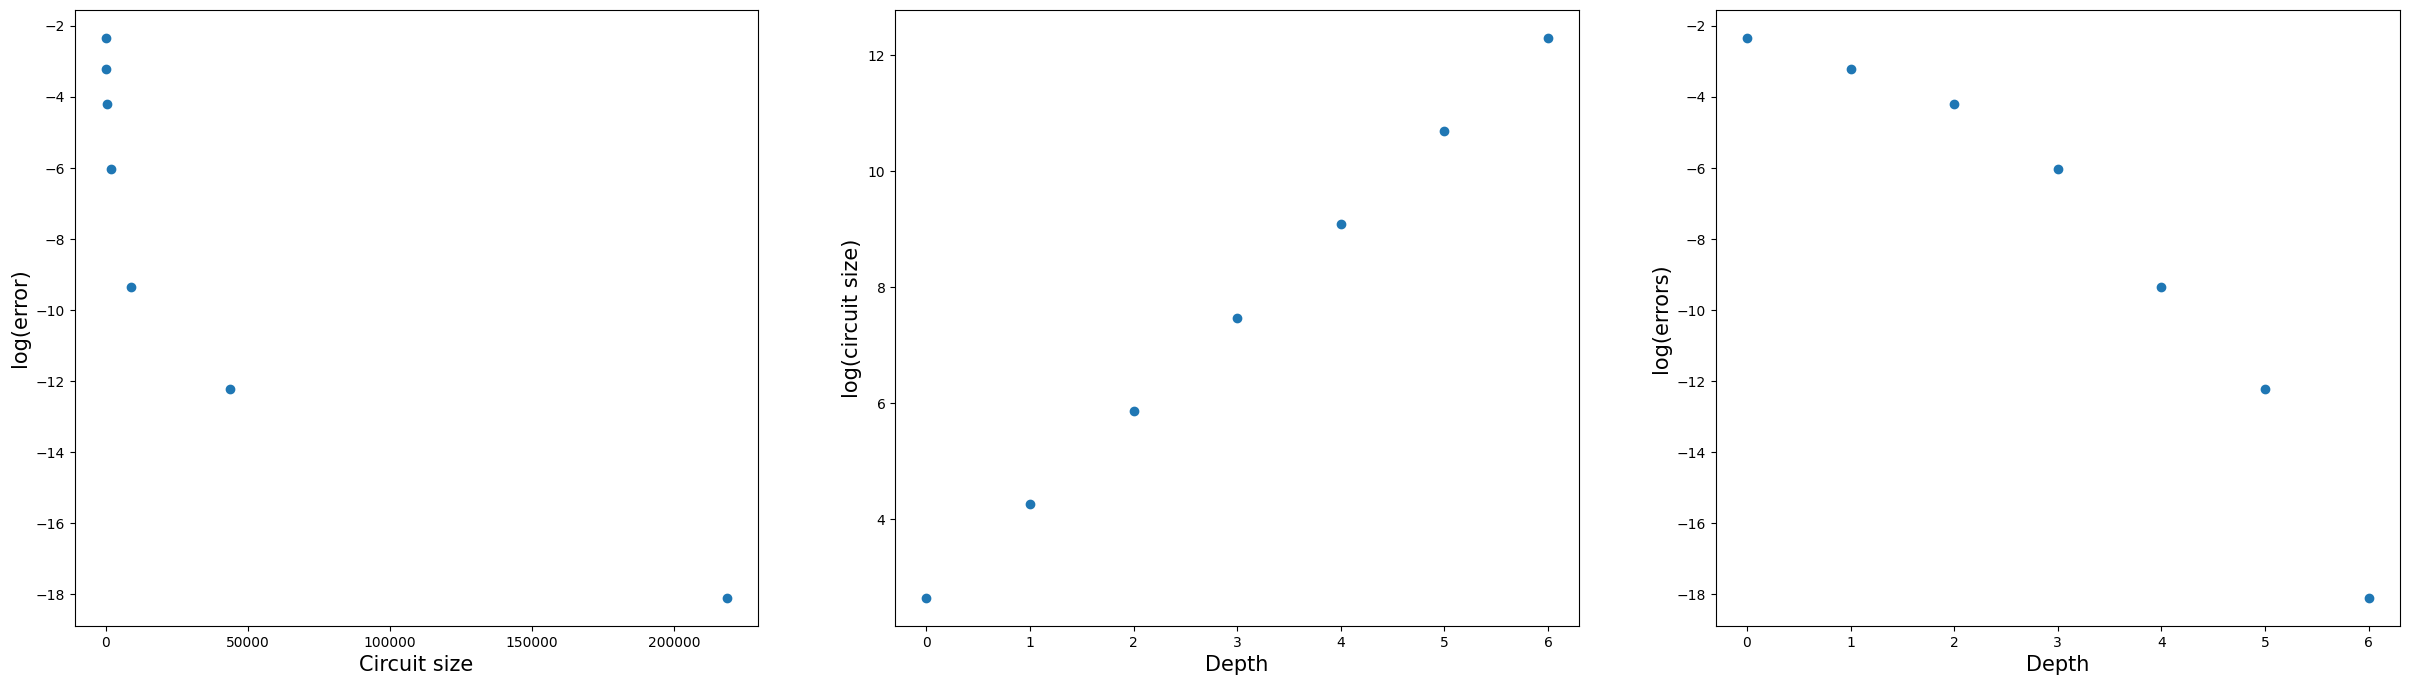

In [16]:
best_gate, hist = solovay_kitaev(gate_to_approx, 
                                 6, 
                                 small_net, 
                                 epsilon_0 = 0.1, 
                                 verbosity = 3, 
                                 scale = 2, 
                                 return_history=True, 
                                 method='meet_in_the_middle', 
                                 scope='last_layer')
plot_history(hist)

A little slower, but defenitely manageable. Let us check how things look like if we use buckets.

## 1.4 Locality Sensitive Hashing 

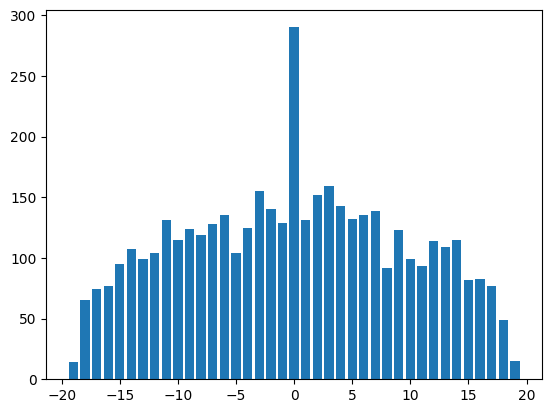

In [13]:
bucket = Bucket(small_net.net, k = 1, bucket_size = 0.1)
bucket.plot_buckets()

In [31]:
bucket_params = {'k': 1, 'bucket_size': 0.1,  'bucket_robustness': 0}
best_gate, hist = solovay_kitaev(gate_to_approx, 
                                 6, 
                                 small_net, 
                                 epsilon_0 = 0.1, 
                                 verbosity = 3, 
                                 scale = 2, 
                                 return_history=True, 
                                 method='meet_in_the_middle', 
                                 scope='last_layer', 
                                 bucket_params=bucket_params)
plot_history(hist)

Total search size:  2916
|------------------------------| 0.0%

Depth 0
Approxiation error: 0.09626015417310642
Number of gates: 14
|------------------------------| 0.0%Error V: 0.09578725727240439
Error W: 0.08874818533466279
Depth 1
Approxiation error: 0.04012623223822376
Number of gates: 70
|------------------------------| 0.7%Error V: 0.025008999823039585
Error W: 0.0717359183373138
Depth 2
Approxiation error: 0.014929972651340748
Number of gates: 350
|------------------------------| 0.0%Error V: 0.015758805488252408
Error W: 0.00623266835225698
Depth 3
Approxiation error: 0.0024215061023637936
Number of gates: 1750
|------------------------------| 0.0%Error V: 0.0013717843130052337
Error W: 0.0011623214653945805
Depth 4
Approxiation error: 8.547326459545812e-05
Number of gates: 8750
|------------------------------| 0.0%Error V: 0.00028411346707585175
Error W: 9.120444765026975e-05
Depth 5
Approxiation error: 4.4887383872102365e-06
Number of gates: 43750
|------------------------------| 1.0%

Definitely faster! The difference will become even more apparent for larger nets as we will see below.

## 1.5 Other examples with $R_x(\sqrt{2})$ and $R_z(\sqrt{3})$

Our first new example will consiste of a random gate in $SU(2)$

|------------------------------| 0.6%Depth 0
Approxiation error: 0.0903345520212753
Number of gates: 9
|------------------------------| 1.3%Error V: 0.0907686069911811
Error W: 0.0931810991356182
Depth 1
Approxiation error: 0.05175110963853421
Number of gates: 49
|------------------------------| 0.0%Error V: 0.0171535206534196
Error W: 0.027284987633784827
Depth 2
Approxiation error: 0.015383493345332103
Number of gates: 217
|------------------------------| 0.0%%Error V: 0.008177680164652007
Error W: 0.007174573601050912
Depth 3
Approxiation error: 0.0031181689747225645
Number of gates: 1091
|------------------------------| 0.0%%Error V: 0.004610259772806977
Error W: 0.001259697453595196
Depth 4
Approxiation error: 0.0005330253265349456
Number of gates: 5333
|------------------------------| 0.0%%Error V: 0.000413497708829761
Error W: 0.00014845230965933987
Depth 5
Approxiation error: 2.0622173459825595e-05
Number of gates: 27425
|------------------------------| 0.0%%Error V: 8.74656275

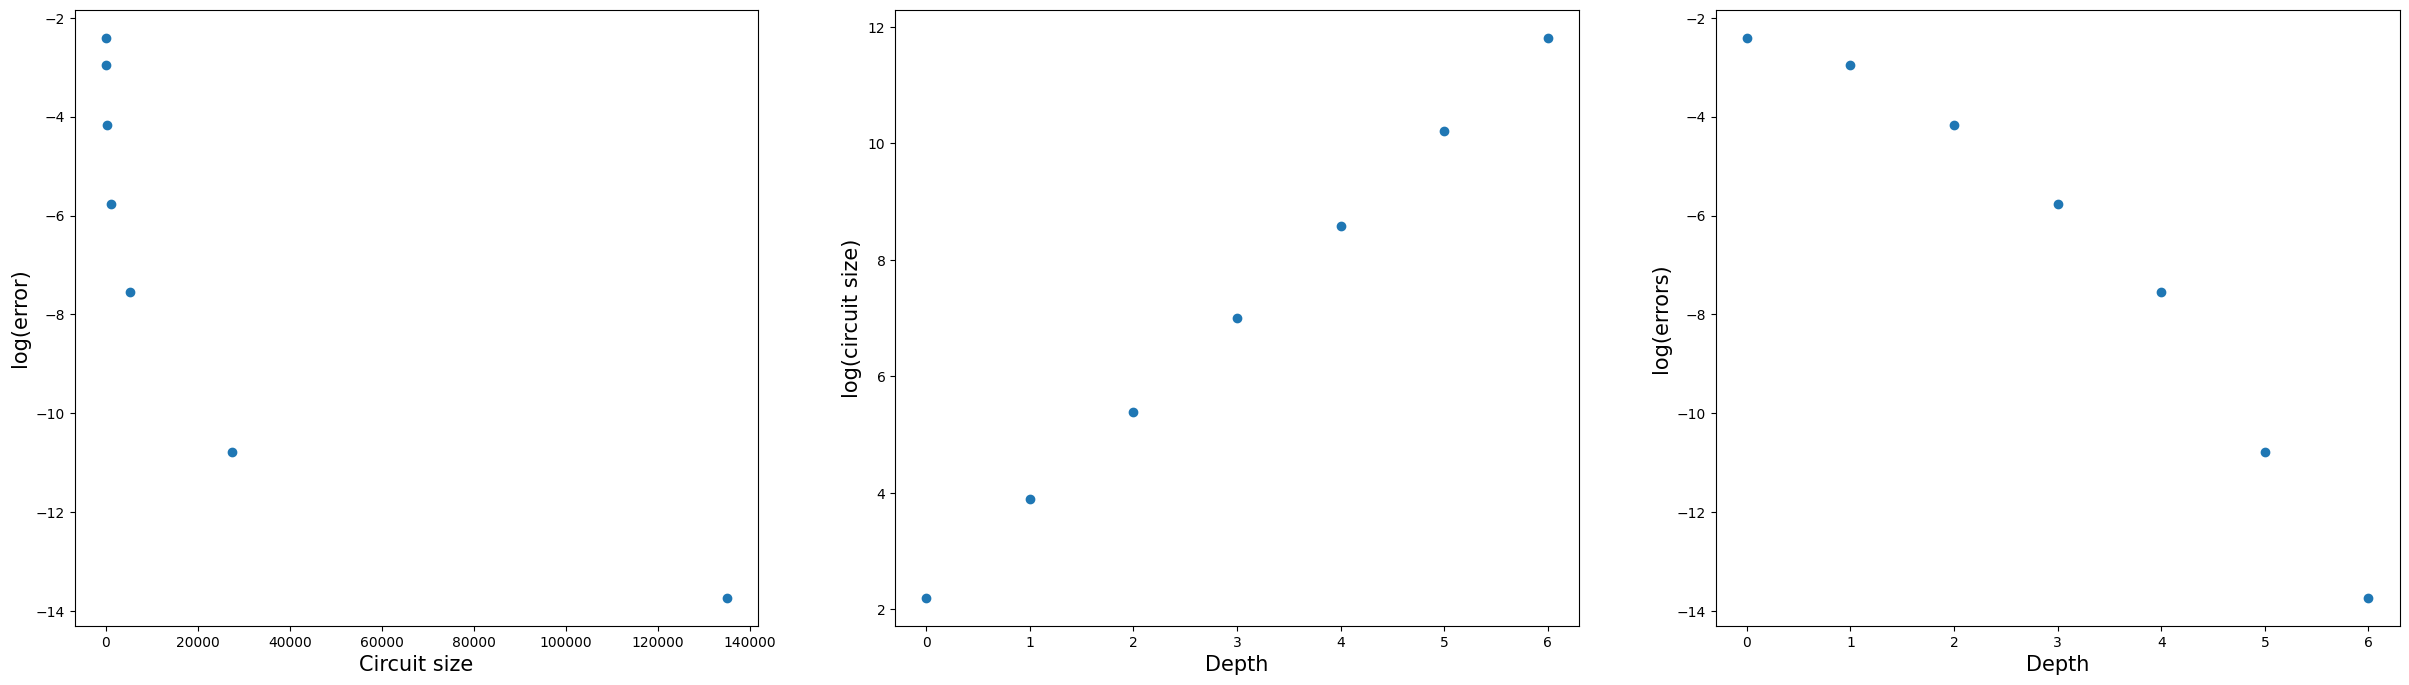

In [37]:
gate_to_approx= su_matrix(2)
best_gate, hist = solovay_kitaev(gate_to_approx, 
                                 6, 
                                 small_net, 
                                 epsilon_0 = 0.1, 
                                 verbosity = 3, 
                                 scale = 2, 
                                 return_history=True, 
                                 method='meet_in_the_middle', 
                                 scope='last_layer', 
                                 bucket_params=bucket_params)
plot_history(hist)

As another example, we will work with a particularly complicated composition of rotations about the $x$ and $z$ axes. By forcing the function arguments to be roots of primes, we ensure that an integer combinations of the generating set cannot be used to compile. 

|------------------------------| 0.6%

|██----------------------------| 7.8%Depth 0
Approxiation error: 0.05164476635964456
Number of gates: 11
|------------------------------| 0.0%Error V: 0.08018616690585056
Error W: 0.09225808533866404
Depth 1
Approxiation error: 0.03162156534577579
Number of gates: 45
|------------------------------| 0.0%Error V: 0.04502275523044203
Error W: 0.0353139706281743
Depth 2
Approxiation error: 0.015615175673163742
Number of gates: 217
|------------------------------| 1.3%%Error V: 0.014531693162632033
Error W: 0.010043997644014343
Depth 3
Approxiation error: 0.00422448682216683
Number of gates: 1187
|------------------------------| 0.0%%Error V: 0.0032365947066643466
Error W: 0.0009833120913737194
Depth 4
Approxiation error: 0.00015451417930088275
Number of gates: 5435
|------------------------------| 0.0%%Error V: 0.0002891605641478223
Error W: 0.0001350329825812167
Depth 5
Approxiation error: 6.401640131573598e-06
Number of gates: 27679
|------------------------------| 0.0%%Error V: 8.17605

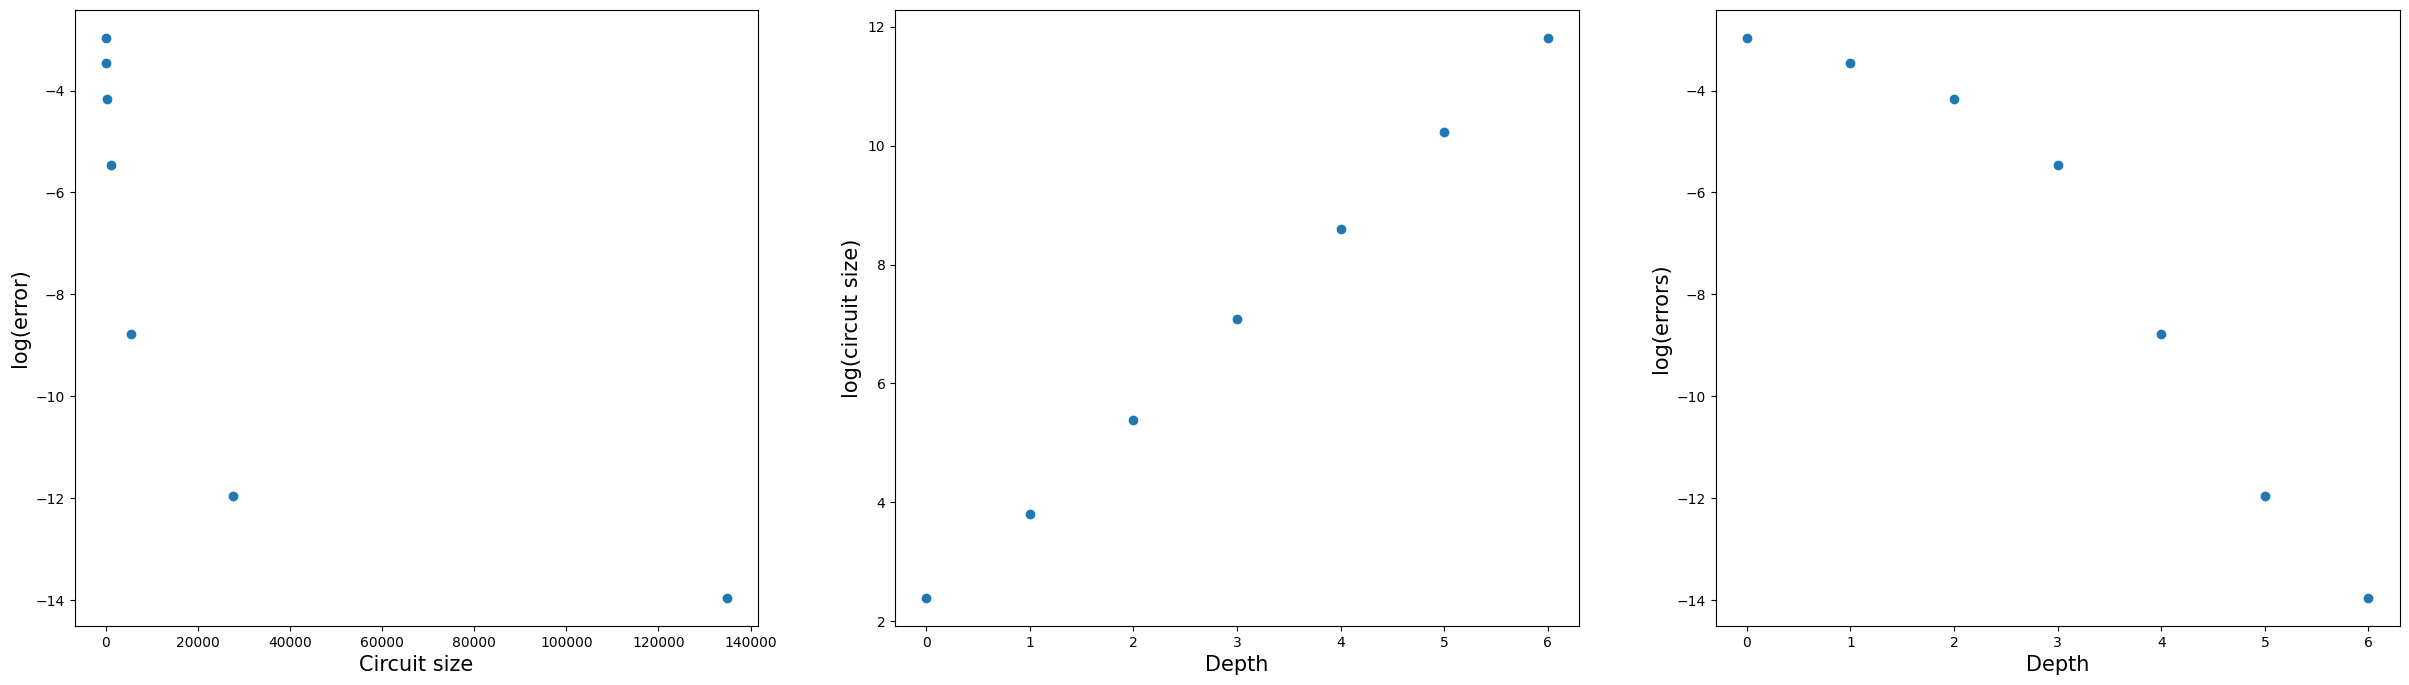

In [38]:
gate_to_approx= Rx(np.sqrt(7)) @ Rz(np.sqrt(13))
best_gate, hist = solovay_kitaev(gate_to_approx, 6, net, epsilon_0 = 0.1, verbosity = 3, scale = 2, return_history=True)
plot_history(hist)

We also test with a T-gate.

|------------------------------| 0.0%

|------------------------------| 1.3%Depth 0
Approxiation error: 0.07975517284621837
Number of gates: 10
|------------------------------| 0.0%Error V: 0.053714912183819644
Error W: 0.06961424598958502
Depth 1
Approxiation error: 0.03320682299149613
Number of gates: 44
|------------------------------| 0.3%Error V: 0.043566877828869595
Error W: 0.03548054838694962
Depth 2
Approxiation error: 0.014760774556136577
Number of gates: 220
|------------------------------| 0.0%%Error V: 0.01819740830586149
Error W: 0.009947991307088566
Depth 3
Approxiation error: 0.0017600918147055906
Number of gates: 1070
|------------------------------| 0.0%%Error V: 0.0036997330363814696
Error W: 0.0017087259339727769
Depth 4
Approxiation error: 0.0002349435251821097
Number of gates: 5382
|------------------------------| 1.6%%Error V: 0.0003243561924868788
Error W: 0.00020626641394788997
Depth 5
Approxiation error: 1.0209981624046357e-05
Number of gates: 27046
|------------------------------| 1.3%%Error V: 7.

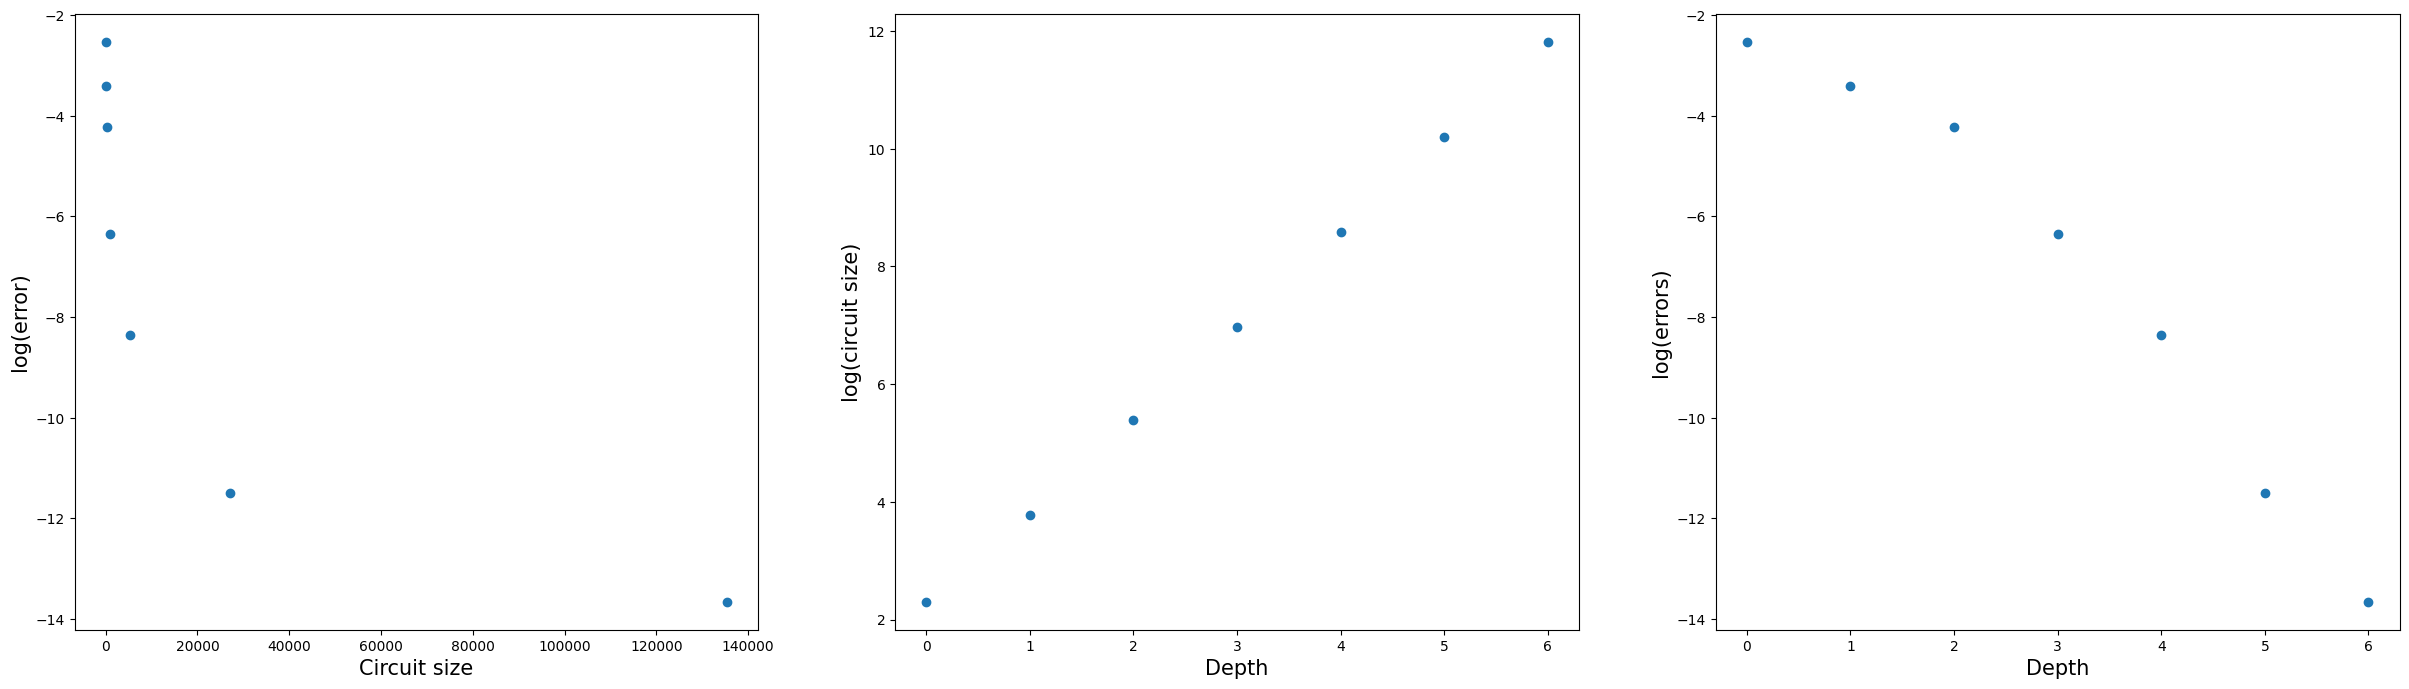

In [39]:
gate_to_approx= np.diag([np.exp(-1j*np.pi/8), np.exp(1j*np.pi/8)])
best_gate, hist = solovay_kitaev(gate_to_approx, 6, net, epsilon_0 = 0.1, verbosity = 3, scale = 2, return_history=True)
plot_history(hist)

# 2. A classical set: Clifford + T
We now explore the universal set Clifford + T. This set is interesting because, as we will see, elements close to the identity only start showing up at very high layers of the net's tree. Let us first try building a very deep net and using linear search.

In [18]:
s1 =  1j/np.sqrt(2)*np.array([[1, 1], [1, -1]])
s2 = np.diag([np.exp(-1j*np.pi/8), np.exp(1j*np.pi/8)])
S2 = np.diag([np.exp(1j*np.pi/8), np.exp(-1j*np.pi/8)])
print('Determinant of gates: ',
      np.linalg.det(s1), np.linalg.det(s2), np.linalg.det(S2))
instr_set = {'s1': s1, 'S1': s1, 's2': s2, 'S2': S2}
instr_set = InstructionSet(instr_set, inverses_provided=True)

Determinant of gates:  (0.9999999999999999+0j) (1+0j) (1+0j)


In [19]:
layers = 10
small_net = SimpleNet(instr_set=instr_set)
small_net.build_net(layers)
print('Net size:', len(small_net))
gate_to_approx = su2_matrix(1, 2, 2)

Net size: 354292


In [20]:
res = small_net.search(gate_to_approx, distance=0.1, verbosity=1)
print('\nApproximated gate:', res[0])
print('Best distance:', res[1])

|█████████████████████████████-| 98.8%
Approximated gate: None
Best distance: 0.14857261038927116


In [21]:
res = small_net.search(gate_to_approx, distance=0.1, verbosity=1, method='meet_in_the_middle')
print('\nApproximated gate:', res[0].instr)
print('Best distance:', res[1])

|------------------------------| 0.0%
Approximated gate: S2.S2.s1.S2.s1.S2.s1.S2.s1.S2.s1.s2
Best distance: 0.08462238428045003


In [23]:
res = small_net.search(gate_to_approx, distance=0.1, verbosity=1, method='meet_in_the_middle', scope='last_layer', shuffle=True)
print('\nApproximated gate:', res[0].instr)
print('Best distance:', res[1])

|------------------------------| 0.0%
Approximated gate: S2.S2.s1.S2.s1.s2.S1.s2.s1.s1.S2.S2.S2.S1.S2.s1.s2.S1.S2.S2.S1.S2
Bes"t distance: 0.08462238428045026


|------------------------------| 0.0%Depth 0
Approxiation error: 0.08462238428049078
Number of gates: 22
|------------------------------| 0.0%Error V: 0.09366264591756308
Error W: 0.07291717968568556
Depth 1
Approxiation error: 0.03759614371833506
Number of gates: 110
|------------------------------| 0.0%Error V: 0.07272515092596535
Error W: 0.05695180791324543
Depth 2
Approxiation error: 0.014937565350827901
Number of gates: 550
|------------------------------| 0.0%Error V: 0.007320424985774788
Error W: 0.014243847669195689
Depth 3
Approxiation error: 0.001245301642674262
Number of gates: 2750
|------------------------------| 0.0%Error V: 0.002518260358009508
Error W: 0.001702300255252222
Depth 4
Approxiation error: 0.00010844555500756342
Number of gates: 13750
|------------------------------| 0.0%Error V: 0.0005228963529630344
Error W: 0.00015036881592681996
Depth 5
Approxiation error: 1.0646856210688105e-05
Number of gates: 68750
|------------------------------| 0.0%Error V: 5.75705

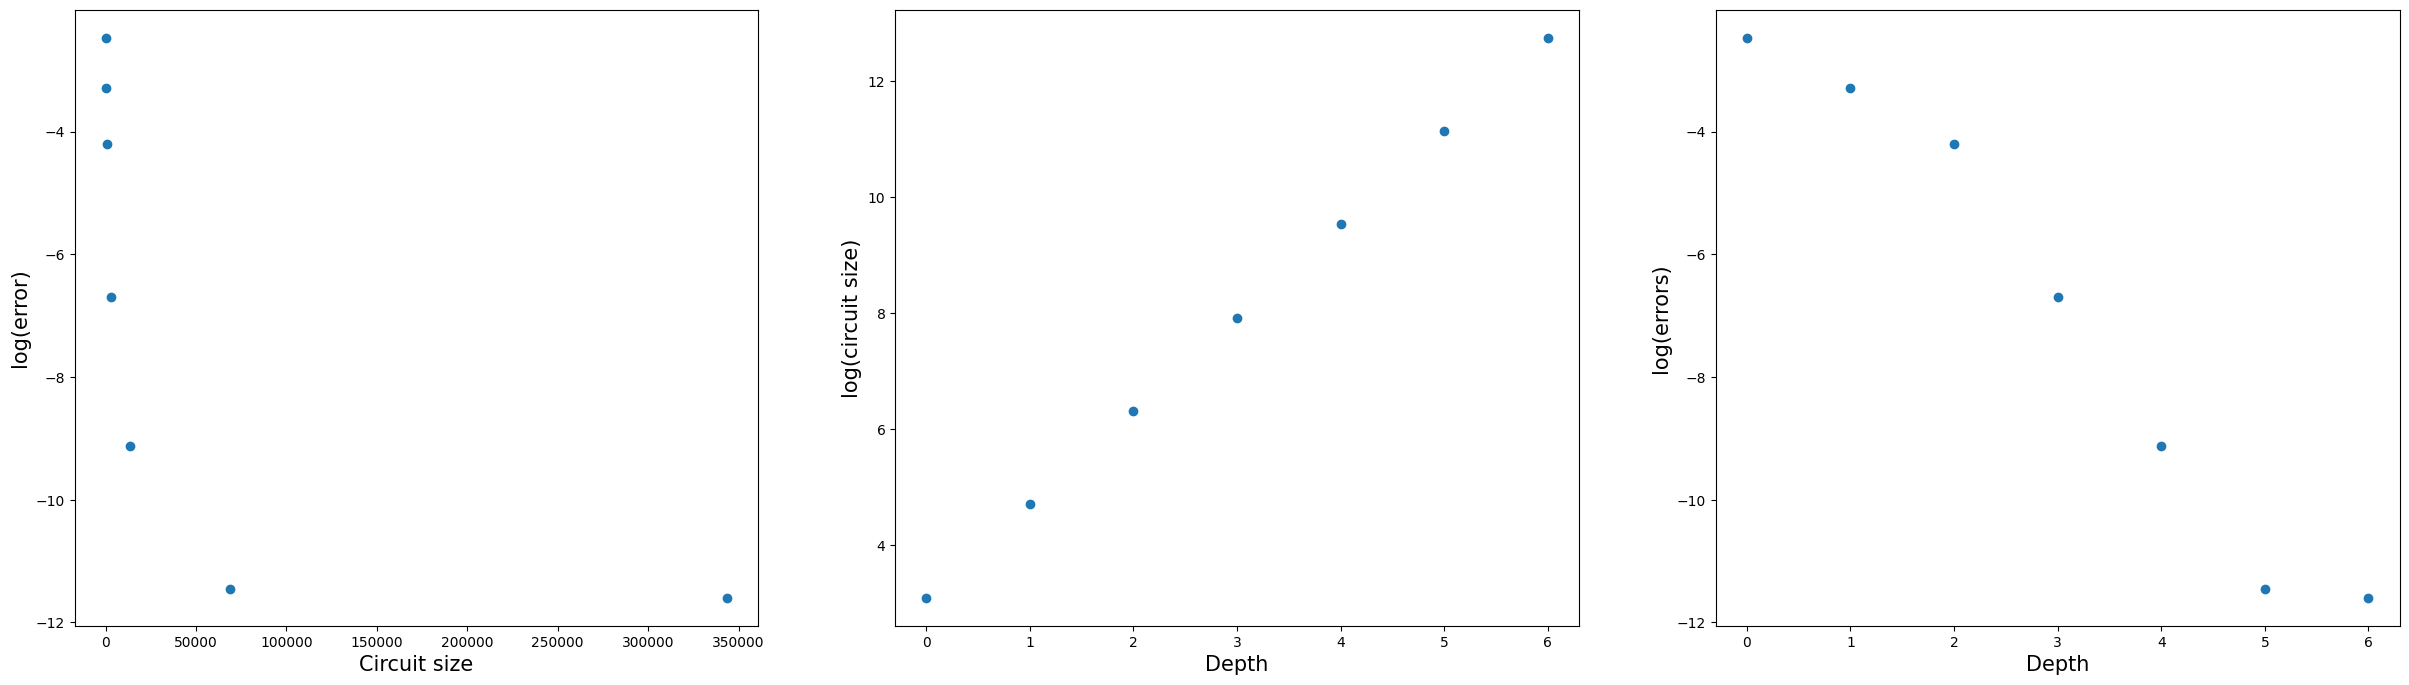

In [30]:
bucket_params = {'k': 3, 'bucket_size': 0.1,  'bucket_robustness': 0}

best_gate, hist = solovay_kitaev(gate_to_approx, 
                                 6, 
                                 small_net, 
                                 epsilon_0 = 0.12,
                                 verbosity = 3,
                                 scale = 2,
                                 return_history=True,
                                 method='meet_in_the_middle',
                                 scope='last_layer',
                                 shuffle=True,
                                 bucket_params=bucket_params)
plot_history(hist)

# 3. Fibonacci braid model 
Now we implement the Fibonacci braid model. Notice that, although the gates form a dense set in $SU(2)$, they use an embedding in $3\times 3$ matrices.